## ResNet Chest X-Ray RGB Classification Model

ไฟล์นี้เป็นโปรแกรมสำหรับฝึก Deep Learning Model (Transfer Learning) เพื่อจำแนกภาพ Chest X-Ray ระหว่าง Normal (ปกติ) และ Pneumonia (ปอดอักเสบ) โดยใช้รูปภาพ RGB ผ่าน ResNet

### ขั้นตอนหลัก:
1. **Import Libraries** - นำเข้าไลบรารี่ที่จำเป็น 
2. **Load และ Prepare Data** - อ่านข้อมูลจากไฟล์และแบ่งเป็น Train/Validation/Test (4084/870/870)
3. **สร้าง Transform** - เตรียมการแปลงรูปภาพ (ขนาด 224×224, Augmentation สำหรับ training)
4. **สร้าง Dataset และ DataLoader** - สร้าง class สำหรับอ่านข้อมูล และปรับสมดุลคลาส


## Library

In [45]:
import os
import zipfile
import pandas as pd

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import recall_score
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import imagehash
from PIL import Image
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Preparation

เรียกใช้ฟังก์ชัน run_cleaning จากไฟล์ clean.py
- จัดการรูปภาพซ้ำด้วย Perceptual Hash (pHash Function)
- การแปลงภาพจากต้นฉบับเป็น RGB เพื่อรองรับ 3 channels และตรงตามรูปแบบโมเดล ResNet50
- Feature Engineering ผ่านการทำ CLAHE
    - ปรับ Contrast ตาม Histogram Equalization แบบปรับตามพื้นที่ (Adaptive HE)

In [46]:
from clean import run_cleaning
df_train_new, df_val_new, df_test_new = run_cleaning()
df_train_new.head()


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🚀 START CLEANING PIPELINE                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 0 — Load DataFrame                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Total files loaded: 5856

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (Cache Found)                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_train.csv

[INFO] Images: 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (Cache Found)                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_val.csv

[INFO] Images: 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (Cache Found)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_test.csv

[INFO] Images: 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (RGB Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_train.csv

[INFO] Images (RGB): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (RGB Cache Found)                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_val.csv

[INFO] Images (RGB): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (RGB Cache Found)                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_test.csv

[INFO] Images (RGB): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (CLAHE Cache Found)                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_train.csv

[INFO] Images (CLAHE): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (CLAHE Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_val.csv

[INFO] Images (CLAHE): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (CLAHE Cache Found)                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_test.csv

[INFO] Images (CLAHE): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🎉 CLEANING COMPLETE                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Train images: 5190

[INFO] Val images:   16

[INFO] Test images:  618

,filepath,label
0,Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


แบ่งชุดการเทรน (Train, Test, Validation set) สำหรับการเรียนรู้โมเดล
- All Dataset: 5,824
    - Training Set: 4,084
    - Validation Set: 870
    - Test Set: 870

In [47]:
from data_split import perform_split

df_train_final, df_val_final, df_test_final = perform_split(
    df_train_new,
    df_val_new,
    df_test_new,
    target_val=870,
    target_test=870
)
df_train_new = df_train_final.copy()
df_test_new = df_test_final.copy()
df_val_new = df_val_final.copy()


STEP: Data Split

[INFO] Remaining train images: 5190

[INFO] Need more = 1106 (val 854, test 252)

     SUMMARY     
                 
  Set     Count  
 ─────────────── 
  Train    4084  
  Val       870  
  Test      870  
  Total    5824 

CHECK OVERLAP

✔ No overlaps detected.

In [48]:
df_test_new['label'].value_counts()

label
1    569
0    301
Name: count, dtype: int64

## Transform pytorch

## การสร้าง Transform และ Dataset สำหรับข้อมูล RGB

ในส่วนนี้จะทำการ:

1. **สร้าง Transform สำหรับ RGB** (ขนาด 224×224)
   - `train_transform_rgb_aug` - สำหรับข้อมูล training พร้อมการ Augmentation (พลิก หมุน ย้าย)
   - `train_transform_rgb_noaug` - สำหรับข้อมูล training (ไม่มี Augmentation)
   - `val_test_transform_rgb` - สำหรับข้อมูล validation และ test (ไม่มี Augmentation)

2. **สร้าง XrayDataset Class** - Class สำหรับอ่านรูปภาพและ label จากไฟล์

3. **สร้าง Balance Function** - ฟังก์ชันสำหรับปรับสมดุลข้อมูล (เพิ่มข้อมูลคลาส Normal และ Pneumonia ให้มีจำนวนใกล้เคียงกัน)

4. **สร้าง Dataset Objects**
   - สำหรับ Training: ข้อมูล Augmented และ Non-Augmented
   - สำหรับ Validation และ Test: ข้อมูล Non-Augmented

5. **สร้าง DataLoader** - เตรียมข้อมูลเป็น batch ขนาด 128 เพื่อใช้ในการฝึกและรองรับรูปแบบของ pytorch


In [49]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# (A) RGB -------------------------------------------------------------------------
train_transform_rgb_aug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_transform_rgb_noaug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform_rgb = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


In [50]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepath"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = torch.tensor(self.labels[idx]).long()
        with Image.open(img_path) as img:
            if self.transform:
                img = self.transform(img)
        return img, label


def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    """
    ทำ balancing แบบ 'เพิ่มเฉพาะจำนวนที่ขาด'
    - original ไม่โดนแก้
    - aug จะทำเฉพาะข้อมูลที่เพิ่มเข้ามา (clone)
    """

    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} → total={len(df)}")

    # คำนวณจำนวนที่ต้องเพิ่ม
    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    # เพิ่มแบบ sampling (augmentation จะไปเกิดใน transform)
    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    # รวม original + aug clones
    df_final = pd.concat([df, df0_aug, df1_aug], axis=0)
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"After : class0={n0 + len(df0_aug)}, class1={n1 + len(df1_aug)} → total={len(df_final)}")

    return df_final



In [51]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=2950, target_1=0)

# -------------------- RGB --------------------
train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

Before: class0=1054, class1=3030 → total=4084
After : class0=2950, class1=3030 → total=5980


In [52]:
batch_size = 128

# --- RGB ---
train_loader_rgb_aug    = DataLoader(train_ds_rgb_aug, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_rgb_noaug  = DataLoader(train_ds_rgb_noaug, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_rgb          = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_rgb         = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)

## Model Config

1. **การกำหนด Device** - ตรวจเช็คและการใช้ device เป็น GPU เพื่อเพิ่มประสิทธิภาพในการทำ Model Training
2. **การกำหนด Train Model Function** - สร้าง def train_model สำหรับการเทรนโมเดล
3. **Config Variables** - การกำหนด Config Variables สำหรับการเทรน
    - NUM_CLASSES = 2: สำหรับคลาสในโจทย์ชุดข้อมูลนี้
    - NUM_EPOCHS = 100: จำนวนการฝึกสอน
    - PATIENCE = 8: จำนวนรอบสำหรับการหยุดโมเดลหาก Gradient ไม่ขยับและกันการเกิด Overfitting
    - batch_size = 128: การแบ่งชุดข้อมูลสำหรับการฝึกกต่อรอบ
    - LEARNING_RATE = 0.001: สำหรับการทำ Backpropagation
    - criterion = nn.CrossEntropyLoss(): สำหรับกลุ่ม Binary Classification
4. **ResNet50** - การโหลด Pretrained Model ผ่าน models จาก PyTorch
5. **Freeze Feature Extractor** - การ Freeze เลเยอร์บนสำหรับการทำ Transfer Learning
6. **Model Training** - การเทรนโมเดลและเก็บผลลัพธ์

In [53]:
!nvidia-smi

Mon Nov 17 20:45:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.97                 Driver Version: 580.97         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P5              3W /   60W |    2693MiB /   4096MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [55]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=5):
    """
    Training loop with validation, early stopping, and logging.
    """
    best_val_acc = 0.0
    best_model_wts = None
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Train {epoch+1}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        
        # --- Validation Phase ---
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Val {epoch+1}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # --- Save history ---
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_acc'].append(epoch_val_acc.item())

        print(f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.4f}")

        # --- Early Stopping Logic ---
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs (no improvement in {patience} epochs).")
            break

    print("\nTraining Complete.")
    print(f"Best Val Acc: {best_val_acc:.4f}")

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, history


In [56]:
NUM_CLASSES = 2
NUM_EPOCHS = 100
PATIENCE = 8
batch_size = 128
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()

ResNet Model 50 Layers (2015)

In [57]:
model_rgb = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [58]:
model_rgb

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Augmented Datasets Training

เทรนโมเดลผ่านชุดข้อมูลที่ผ่านกระบวนการ Data Augmented

In [59]:
# Freeze feature extractor
for param in model_rgb.parameters():
    param.requires_grad = False

num_ftrs_rgb = model_rgb.fc.in_features
model_rgb.fc = nn.Linear(num_ftrs_rgb, NUM_CLASSES)
model_rgb = model_rgb.to(device)

optimizer_rgb = optim.Adam(model_rgb.fc.parameters(), lr=LEARNING_RATE)

In [60]:
model_rgb, history_rgb = train_model(
    model_rgb, 
    train_loader_rgb_aug, 
    val_loader_rgb, 
    criterion, 
    optimizer_rgb, 
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)


Epoch 1/100
----------------------------------------


Val 1: 100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Train Loss: 0.4169 | Acc: 0.8453
Val   Loss: 0.3712 | Acc: 0.8690

Epoch 2/100
----------------------------------------


Val 2: 100%|██████████| 7/7 [00:17<00:00,  2.56s/it]


Train Loss: 0.2645 | Acc: 0.9077
Val   Loss: 0.2738 | Acc: 0.8851

Epoch 3/100
----------------------------------------


Val 3: 100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Train Loss: 0.2263 | Acc: 0.9161
Val   Loss: 0.2332 | Acc: 0.9023

Epoch 4/100
----------------------------------------


Val 4: 100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Train Loss: 0.2063 | Acc: 0.9273
Val   Loss: 0.2333 | Acc: 0.9057

Epoch 5/100
----------------------------------------


Val 5: 100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


Train Loss: 0.1975 | Acc: 0.9239
Val   Loss: 0.2256 | Acc: 0.9126

Epoch 6/100
----------------------------------------


Val 6: 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


Train Loss: 0.1790 | Acc: 0.9355
Val   Loss: 0.2015 | Acc: 0.9184

Epoch 7/100
----------------------------------------


Val 7: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it]


Train Loss: 0.1722 | Acc: 0.9361
Val   Loss: 0.2023 | Acc: 0.9184

Epoch 8/100
----------------------------------------


Val 8: 100%|██████████| 7/7 [00:25<00:00,  3.57s/it]


Train Loss: 0.1665 | Acc: 0.9385
Val   Loss: 0.1863 | Acc: 0.9264

Epoch 9/100
----------------------------------------


Val 9: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Train Loss: 0.1666 | Acc: 0.9346
Val   Loss: 0.2028 | Acc: 0.9241

Epoch 10/100
----------------------------------------


Val 10: 100%|██████████| 7/7 [00:20<00:00,  2.99s/it]


Train Loss: 0.1548 | Acc: 0.9457
Val   Loss: 0.1810 | Acc: 0.9276

Epoch 11/100
----------------------------------------


Val 11: 100%|██████████| 7/7 [00:24<00:00,  3.54s/it]


Train Loss: 0.1484 | Acc: 0.9463
Val   Loss: 0.1741 | Acc: 0.9299

Epoch 12/100
----------------------------------------


Val 12: 100%|██████████| 7/7 [00:24<00:00,  3.54s/it]


Train Loss: 0.1518 | Acc: 0.9431
Val   Loss: 0.1849 | Acc: 0.9299

Epoch 13/100
----------------------------------------


Val 13: 100%|██████████| 7/7 [00:24<00:00,  3.54s/it]


Train Loss: 0.1500 | Acc: 0.9435
Val   Loss: 0.1883 | Acc: 0.9287

Epoch 14/100
----------------------------------------


Val 14: 100%|██████████| 7/7 [00:24<00:00,  3.51s/it]


Train Loss: 0.1495 | Acc: 0.9448
Val   Loss: 0.1827 | Acc: 0.9322

Epoch 15/100
----------------------------------------


Val 15: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Train Loss: 0.1403 | Acc: 0.9477
Val   Loss: 0.1653 | Acc: 0.9356

Epoch 16/100
----------------------------------------


Val 16: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Train Loss: 0.1459 | Acc: 0.9492
Val   Loss: 0.1690 | Acc: 0.9345

Epoch 17/100
----------------------------------------


Val 17: 100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Train Loss: 0.1436 | Acc: 0.9483
Val   Loss: 0.1809 | Acc: 0.9287

Epoch 18/100
----------------------------------------


Val 18: 100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


Train Loss: 0.1378 | Acc: 0.9510
Val   Loss: 0.1713 | Acc: 0.9333

Epoch 19/100
----------------------------------------


Val 19: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Train Loss: 0.1348 | Acc: 0.9480
Val   Loss: 0.1690 | Acc: 0.9368

Epoch 20/100
----------------------------------------


Val 20: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


Train Loss: 0.1310 | Acc: 0.9530
Val   Loss: 0.1678 | Acc: 0.9345

Epoch 21/100
----------------------------------------


Val 21: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Train Loss: 0.1355 | Acc: 0.9510
Val   Loss: 0.1650 | Acc: 0.9368

Epoch 22/100
----------------------------------------


Val 22: 100%|██████████| 7/7 [00:18<00:00,  2.58s/it]


Train Loss: 0.1320 | Acc: 0.9542
Val   Loss: 0.1789 | Acc: 0.9287

Epoch 23/100
----------------------------------------


Val 23: 100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Train Loss: 0.1315 | Acc: 0.9507
Val   Loss: 0.1621 | Acc: 0.9414

Epoch 24/100
----------------------------------------


Val 24: 100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Train Loss: 0.1377 | Acc: 0.9498
Val   Loss: 0.1631 | Acc: 0.9391

Epoch 25/100
----------------------------------------


Val 25: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Train Loss: 0.1323 | Acc: 0.9525
Val   Loss: 0.1528 | Acc: 0.9391

Epoch 26/100
----------------------------------------


Val 26: 100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Train Loss: 0.1276 | Acc: 0.9503
Val   Loss: 0.1514 | Acc: 0.9368

Epoch 27/100
----------------------------------------


Val 27: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


Train Loss: 0.1216 | Acc: 0.9562
Val   Loss: 0.1609 | Acc: 0.9437

Epoch 28/100
----------------------------------------


Val 28: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


Train Loss: 0.1272 | Acc: 0.9555
Val   Loss: 0.1680 | Acc: 0.9379

Epoch 29/100
----------------------------------------


Val 29: 100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Train Loss: 0.1219 | Acc: 0.9567
Val   Loss: 0.1511 | Acc: 0.9402

Epoch 30/100
----------------------------------------


Val 30: 100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Train Loss: 0.1249 | Acc: 0.9528
Val   Loss: 0.1456 | Acc: 0.9414

Epoch 31/100
----------------------------------------


Val 31: 100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


Train Loss: 0.1238 | Acc: 0.9572
Val   Loss: 0.1581 | Acc: 0.9402

Epoch 32/100
----------------------------------------


Val 32: 100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


Train Loss: 0.1264 | Acc: 0.9533
Val   Loss: 0.1475 | Acc: 0.9414

Epoch 33/100
----------------------------------------


Val 33: 100%|██████████| 7/7 [00:24<00:00,  3.46s/it]


Train Loss: 0.1214 | Acc: 0.9548
Val   Loss: 0.1562 | Acc: 0.9437

Epoch 34/100
----------------------------------------


Val 34: 100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Train Loss: 0.1197 | Acc: 0.9554
Val   Loss: 0.1566 | Acc: 0.9448

Epoch 35/100
----------------------------------------


Val 35: 100%|██████████| 7/7 [00:24<00:00,  3.51s/it]


Train Loss: 0.1212 | Acc: 0.9538
Val   Loss: 0.1576 | Acc: 0.9483

Epoch 36/100
----------------------------------------


Val 36: 100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


Train Loss: 0.1153 | Acc: 0.9555
Val   Loss: 0.1382 | Acc: 0.9460

Epoch 37/100
----------------------------------------


Val 37: 100%|██████████| 7/7 [00:25<00:00,  3.57s/it]


Train Loss: 0.1211 | Acc: 0.9540
Val   Loss: 0.1455 | Acc: 0.9425

Epoch 38/100
----------------------------------------


Val 38: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Train Loss: 0.1186 | Acc: 0.9552
Val   Loss: 0.1470 | Acc: 0.9460

Epoch 39/100
----------------------------------------


Val 39: 100%|██████████| 7/7 [00:24<00:00,  3.54s/it]


Train Loss: 0.1149 | Acc: 0.9590
Val   Loss: 0.1492 | Acc: 0.9448

Epoch 40/100
----------------------------------------


Val 40: 100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


Train Loss: 0.1234 | Acc: 0.9540
Val   Loss: 0.1717 | Acc: 0.9368

Epoch 41/100
----------------------------------------


Val 41: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Train Loss: 0.1205 | Acc: 0.9555
Val   Loss: 0.1465 | Acc: 0.9483

Epoch 42/100
----------------------------------------


Val 42: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Train Loss: 0.1089 | Acc: 0.9605
Val   Loss: 0.1459 | Acc: 0.9425

Epoch 43/100
----------------------------------------


Val 43: 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]

Train Loss: 0.1178 | Acc: 0.9555
Val   Loss: 0.1464 | Acc: 0.9448

Early stopping triggered after 43 epochs (no improvement in 8 epochs).

Training Complete.
Best Val Acc: 0.9483


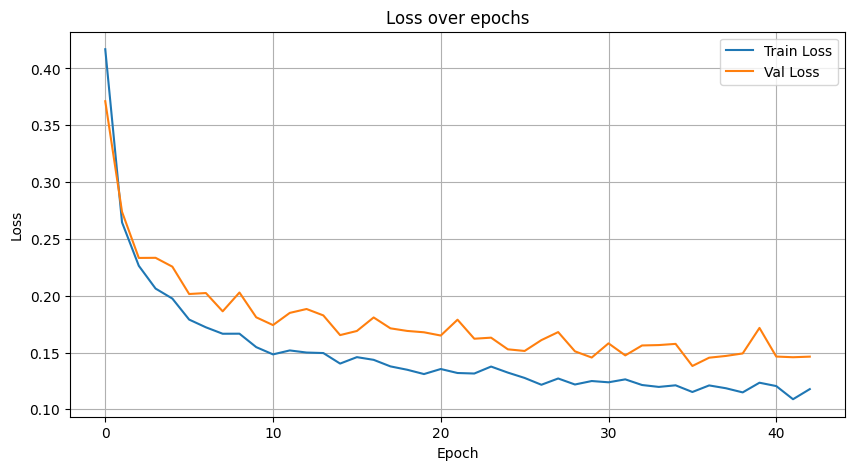

In [61]:
plt.figure(figsize=(10,5))
plt.plot(history_rgb['train_loss'], label='Train Loss')
plt.plot(history_rgb['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
def evaluate_model(model, test_loader, class_names=None):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating [Test]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # --- Metrics ---
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print("\n--- Test Set Performance ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}


Evaluating [Test]: 100%|██████████| 7/7 [00:28<00:00,  4.03s/it]



--- Test Set Performance ---
Accuracy : 0.8943
Precision: 0.8949
Recall   : 0.8943
F1-score : 0.8922

Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.78      0.84       301
   Pneumonia       0.89      0.96      0.92       569

    accuracy                           0.89       870
   macro avg       0.90      0.87      0.88       870
weighted avg       0.89      0.89      0.89       870



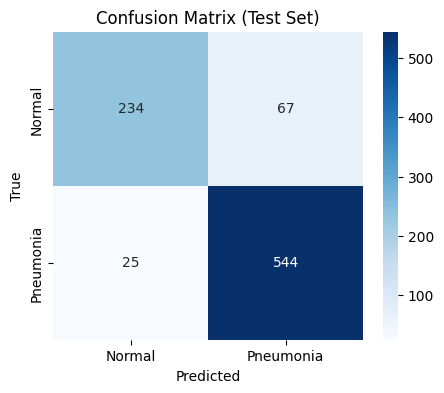

In [63]:
class_names = ["Normal", "Pneumonia"]

test_metrics = evaluate_model(model_rgb, test_loader_rgb, class_names)

In [64]:
# torch.save(model_rgb, "ResNetX2_augmented.pt")

## Non-Augmented Datasets Training

เทรนโมเดลผ่านชุดข้อมูลที่ไม่ผ่านกระบวนการ Data Augmented (Data ปกติ)

In [65]:
model_rgb_2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze feature extractor
for param in model_rgb_2.parameters():
    param.requires_grad = False

num_ftrs_rgb = model_rgb_2.fc.in_features
model_rgb_2.fc = nn.Linear(num_ftrs_rgb, NUM_CLASSES)
model_rgb_2 = model_rgb_2.to(device)

optimizer_rgb = optim.Adam(model_rgb_2.fc.parameters(), lr=LEARNING_RATE)

In [66]:
model_rgb_2, history_rgb_2 = train_model(
    model_rgb_2, 
    train_loader_rgb_noaug, 
    val_loader_rgb, 
    criterion, 
    optimizer_rgb, 
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)


Epoch 1/100
----------------------------------------


Val 1: 100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


Train Loss: 0.4174 | Acc: 0.8159
Val   Loss: 0.3991 | Acc: 0.8805

Epoch 2/100
----------------------------------------


Val 2: 100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


Train Loss: 0.2479 | Acc: 0.9177
Val   Loss: 0.2600 | Acc: 0.9195

Epoch 3/100
----------------------------------------


Val 3: 100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


Train Loss: 0.2026 | Acc: 0.9324
Val   Loss: 0.1921 | Acc: 0.9345

Epoch 4/100
----------------------------------------


Val 4: 100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


Train Loss: 0.1780 | Acc: 0.9368
Val   Loss: 0.1738 | Acc: 0.9414

Epoch 5/100
----------------------------------------


Val 5: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Train Loss: 0.1661 | Acc: 0.9429
Val   Loss: 0.1648 | Acc: 0.9310

Epoch 6/100
----------------------------------------


Val 6: 100%|██████████| 7/7 [00:24<00:00,  3.50s/it]


Train Loss: 0.1525 | Acc: 0.9469
Val   Loss: 0.1545 | Acc: 0.9425

Epoch 7/100
----------------------------------------


Val 7: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Train Loss: 0.1436 | Acc: 0.9515
Val   Loss: 0.1564 | Acc: 0.9402

Epoch 8/100
----------------------------------------


Val 8: 100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


Train Loss: 0.1365 | Acc: 0.9520
Val   Loss: 0.1454 | Acc: 0.9483

Epoch 9/100
----------------------------------------


Val 9: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Train Loss: 0.1321 | Acc: 0.9540
Val   Loss: 0.1408 | Acc: 0.9437

Epoch 10/100
----------------------------------------


Val 10: 100%|██████████| 7/7 [00:24<00:00,  3.50s/it]


Train Loss: 0.1252 | Acc: 0.9567
Val   Loss: 0.1373 | Acc: 0.9437

Epoch 11/100
----------------------------------------


Val 11: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Train Loss: 0.1157 | Acc: 0.9623
Val   Loss: 0.1351 | Acc: 0.9460

Epoch 12/100
----------------------------------------


Val 12: 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


Train Loss: 0.1122 | Acc: 0.9633
Val   Loss: 0.1347 | Acc: 0.9471

Epoch 13/100
----------------------------------------


Val 13: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Train Loss: 0.1101 | Acc: 0.9628
Val   Loss: 0.1328 | Acc: 0.9483

Epoch 14/100
----------------------------------------


Val 14: 100%|██████████| 7/7 [00:24<00:00,  3.46s/it]


Train Loss: 0.1084 | Acc: 0.9647
Val   Loss: 0.1306 | Acc: 0.9517

Epoch 15/100
----------------------------------------


Val 15: 100%|██████████| 7/7 [00:23<00:00,  3.35s/it]


Train Loss: 0.0998 | Acc: 0.9711
Val   Loss: 0.1291 | Acc: 0.9494

Epoch 16/100
----------------------------------------


Val 16: 100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


Train Loss: 0.0972 | Acc: 0.9691
Val   Loss: 0.1266 | Acc: 0.9540

Epoch 17/100
----------------------------------------


Val 17: 100%|██████████| 7/7 [00:23<00:00,  3.33s/it]


Train Loss: 0.0941 | Acc: 0.9704
Val   Loss: 0.1264 | Acc: 0.9494

Epoch 18/100
----------------------------------------


Val 18: 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


Train Loss: 0.0938 | Acc: 0.9701
Val   Loss: 0.1251 | Acc: 0.9483

Epoch 19/100
----------------------------------------


Val 19: 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


Train Loss: 0.0925 | Acc: 0.9706
Val   Loss: 0.1261 | Acc: 0.9517

Epoch 20/100
----------------------------------------


Val 20: 100%|██████████| 7/7 [00:23<00:00,  3.31s/it]


Train Loss: 0.0878 | Acc: 0.9709
Val   Loss: 0.1230 | Acc: 0.9517

Epoch 21/100
----------------------------------------


Val 21: 100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


Train Loss: 0.0821 | Acc: 0.9760
Val   Loss: 0.1217 | Acc: 0.9540

Epoch 22/100
----------------------------------------


Val 22: 100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


Train Loss: 0.0815 | Acc: 0.9753
Val   Loss: 0.1223 | Acc: 0.9494

Epoch 23/100
----------------------------------------


Val 23: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


Train Loss: 0.0804 | Acc: 0.9765
Val   Loss: 0.1210 | Acc: 0.9552

Epoch 24/100
----------------------------------------


Val 24: 100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Train Loss: 0.0787 | Acc: 0.9767
Val   Loss: 0.1208 | Acc: 0.9563

Epoch 25/100
----------------------------------------


Val 25: 100%|██████████| 7/7 [00:23<00:00,  3.33s/it]


Train Loss: 0.0784 | Acc: 0.9767
Val   Loss: 0.1248 | Acc: 0.9517

Epoch 26/100
----------------------------------------


Val 26: 100%|██████████| 7/7 [00:23<00:00,  3.32s/it]


Train Loss: 0.0742 | Acc: 0.9785
Val   Loss: 0.1204 | Acc: 0.9552

Epoch 27/100
----------------------------------------


Val 27: 100%|██████████| 7/7 [00:23<00:00,  3.36s/it]


Train Loss: 0.0716 | Acc: 0.9787
Val   Loss: 0.1198 | Acc: 0.9540

Epoch 28/100
----------------------------------------


Val 28: 100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


Train Loss: 0.0711 | Acc: 0.9807
Val   Loss: 0.1184 | Acc: 0.9529

Epoch 29/100
----------------------------------------


Val 29: 100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Train Loss: 0.0690 | Acc: 0.9838
Val   Loss: 0.1216 | Acc: 0.9517

Epoch 30/100
----------------------------------------


Val 30: 100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Train Loss: 0.0695 | Acc: 0.9799
Val   Loss: 0.1188 | Acc: 0.9506

Epoch 31/100
----------------------------------------


Val 31: 100%|██████████| 7/7 [00:16<00:00,  2.43s/it]


Train Loss: 0.0658 | Acc: 0.9816
Val   Loss: 0.1188 | Acc: 0.9529

Epoch 32/100
----------------------------------------


Val 32: 100%|██████████| 7/7 [00:17<00:00,  2.48s/it]

Train Loss: 0.0637 | Acc: 0.9833
Val   Loss: 0.1188 | Acc: 0.9540

Early stopping triggered after 32 epochs (no improvement in 8 epochs).

Training Complete.
Best Val Acc: 0.9563


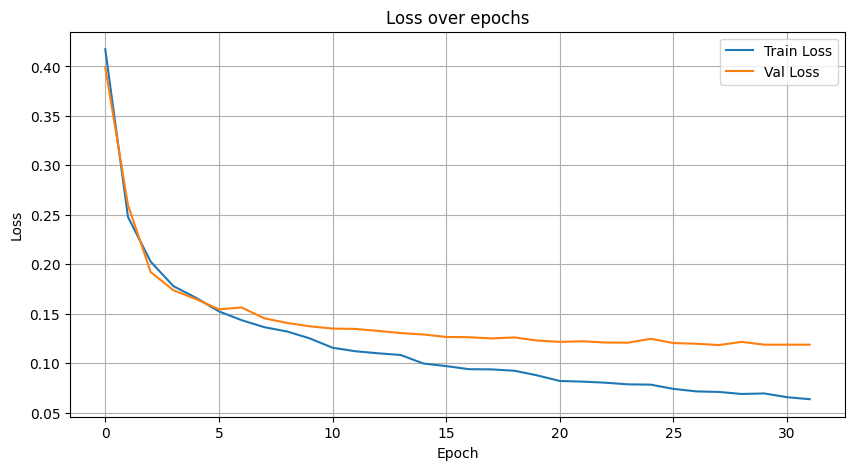

In [67]:
plt.figure(figsize=(10,5))
plt.plot(history_rgb_2['train_loss'], label='Train Loss')
plt.plot(history_rgb_2['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Evaluating [Test]: 100%|██████████| 7/7 [00:19<00:00,  2.76s/it]


--- Test Set Performance ---
Accuracy : 0.8724
Precision: 0.8798
Recall   : 0.8724
F1-score : 0.8667

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.68      0.79       301
   Pneumonia       0.85      0.97      0.91       569

    accuracy                           0.87       870
   macro avg       0.89      0.83      0.85       870
weighted avg       0.88      0.87      0.87       870



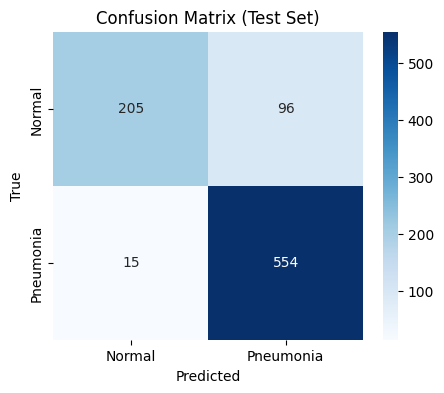

In [68]:
# class_names = ["Normal", "Pneumonia"]

test_metrics_2 = evaluate_model(model_rgb_2, test_loader_rgb, class_names)

In [69]:
# torch.save(model_rgb, "ResNetX2_non-augmented.pt")

## Comparison

1. **Loss Comparison** - เปรียบเทียบค่า Loss ระหว่าง 2 โมเดลที่เกิดขึ้น (Augmented vs Non-Augmented)
2. **Confusion Matrix** - เปรียบเทียบ Confusion Matrix บนชุด test ของทั้ง 2 โมเดล

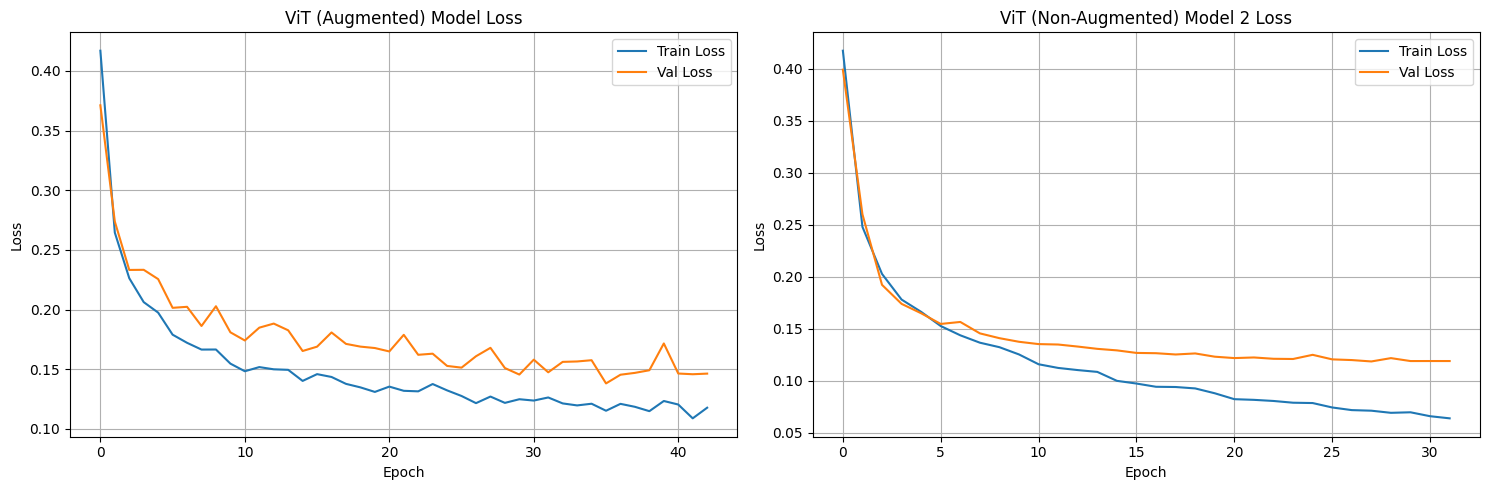

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))  

axes[0].plot(history_rgb['train_loss'], label='Train Loss')
axes[0].plot(history_rgb['val_loss'], label='Val Loss')
axes[0].set_title('ResNet (Augmented) Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_rgb_2['train_loss'], label='Train Loss')
axes[1].plot(history_rgb_2['val_loss'], label='Val Loss')
axes[1].set_title('ResNet (Non-Augmented) Model 2 Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()  
plt.show()


In [76]:
def plot_two_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    cm1 = confusion_matrix(y_true1, y_pred1)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Model 1 (Augmented) Confusion Matrix')

    cm2 = confusion_matrix(y_true2, y_pred2)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Model 2 (Non-Augmented) Confusion Matrix')

    plt.tight_layout()
    plt.show()


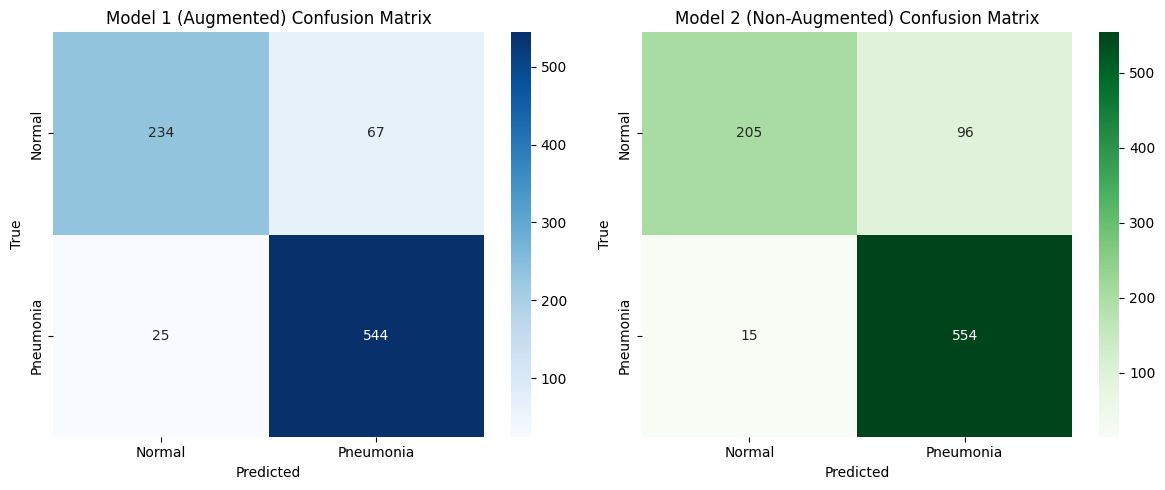

In [77]:
y_true1, y_pred1 = [], []
y_true2, y_pred2 = [], []

model_rgb.eval()
with torch.no_grad():
    for inputs, labels in test_loader_rgb:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_rgb(inputs)
        _, preds = torch.max(outputs, 1)
        y_true1.extend(labels.cpu().numpy())
        y_pred1.extend(preds.cpu().numpy())

model_rgb_2.eval()
with torch.no_grad():
    for inputs, labels in test_loader_rgb:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_rgb_2(inputs)
        _, preds = torch.max(outputs, 1)
        y_true2.extend(labels.cpu().numpy())
        y_pred2.extend(preds.cpu().numpy())

plot_two_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, class_names)

In [73]:
def evaluate_classification_report(model, test_loader, class_names=None):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating [Report Only]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [74]:
print("\n### Model 1 Classification Report (Augmented) ###")
evaluate_classification_report(model_rgb, test_loader_rgb, class_names)

print("\n### Model 2 Classification Report (Non-Augmented) ###")
evaluate_classification_report(model_rgb_2, test_loader_rgb, class_names)


### Model 1 Classification Report (Augmented) ###


Evaluating [Report Only]: 100%|██████████| 7/7 [00:35<00:00,  5.01s/it]



=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.90      0.78      0.84       301
   Pneumonia       0.89      0.96      0.92       569

    accuracy                           0.89       870
   macro avg       0.90      0.87      0.88       870
weighted avg       0.89      0.89      0.89       870


### Model 2 Classification Report (Non-Augmented) ###


Evaluating [Report Only]: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.93      0.68      0.79       301
   Pneumonia       0.85      0.97      0.91       569

    accuracy                           0.87       870
   macro avg       0.89      0.83      0.85       870
weighted avg       0.88      0.87      0.87       870



## Recap Summary Result ResNet Model

การเปรียบเทียบระหว่างโมเดลที่ผ่านการฝึกในรูปแบบ Augmented vs Non-Augmented

### Loss of Model
- **โมเดลที่ 1 (Augmented)** มีค่า loss ที่สูงกว่าและการแหว่งของ loss กว่าโมเดลที่ 2 (Non-Augmented) การแกว่งที่เกิดขึ้นสามารถบ่งบอกถึงความยากของแบบชุดทดสอบได้ ในขณะเดียวกันการจัดปัญหา Overfitting จะทำได้ดีกว่า
- **โมเดลที่ 2 (Non-Augmented)** มีค่า loss ต่ำกว่าโมเดลที่ 1 และความเสถียรที่มากกว่า แต่มีโอกาสเกิด Overfitting ได้สูงมากกว่าถึงแม้มีค่า loss ที่เสถียร ซึ่งหนึ่งในปัญหาที่เกิดขึ้นกับโมเดลนี้คือเทรนบน (Non-Augmented) ซึ่งมี Class Imbalanced เป็นปัญหาหลัก

### Confusion Matrix
- **FP: Pneumonia but Predicted is Normal**
- **FN: Normal but Predicted is Pneumonia**

    - **โมเดลที่ 1 (Augmented)** การทำนายบน FP และ FN ใกล้เคียงกัน โดย FP = 25, FN = 67
    - **โมเดลที่ 2 (Non-Augmented)** การทำนายบน FP มีต่ำกว่าและค่า FN อยู่มากพอสมควร FP = 15, FN = 96

ซึ่งในโจทย์นี้จำเป็นต้องมีการลด FN ให้ได้มากที่สุด ซึ่งโมเดลที่ 1 (Augmented) ตอบโจทย์มากกว่า

### Classification Report
โดยจุดโฟกัสหลักของโจทย์นี้จะเน้นที่ Recall, F1 และ 

- **โมเดลที่ 1 (Augmented)** 
    - Recall: ทำได้ดีมากโดยเฉพาะในคลาสของ Pneumonia และมีความแตกต่างของคลาสเล็กน้อย (ห่างกัน 0.18) ซึ่งทำได้ดี
    - F1: ค่า trade-off ระหว่าง Precision และ Recall จะสังเกตเห็นความสมดุลที่เพิ่มขึ้นมาในคลาสของ Normal
    - Accuracy: 0.89 อยู่ในเกณฑ์ใกล้เตียงที่ดี บ่งบอกประสิทธิภาพของโมเดลที่ Generalize ได้ดีในระดับนึง และดีมากสำหรับคลาส Pneumonia

- **โมเดลที่ 2 (Non-Augmented)**
    - Recall: มีค่า Recall ที่สูงกว่าโมเดลที่ 1 อยู่เล็กน้อย แต่ในขณะเดียวกันจะเห็นปัญหาของ class imbalanced ได้อย่างชัดเจนจาก Recall ของ Normal Class เพียง 0.68
    - F1: ค่า trade-off ระหว่าง Precision และ Recall เห็นได้ชัดว่า มีประสิทธิภาพน้อยกว่าโมเดลที่ 1 อย่างชัดเจน โดยเฉพาะ Normal Class
    - Accuracy: 0.87 อยู่ในเกณฑ์ปานกลาง โดยยังไม่ดีเท่าโมเดลที่ 1 ในเชิงของภาพรวม

## เปรียบเทียบผล (Test Set)

| Metric | Aug | NoAug |
|--------|-----|-------|
| Accuracy | 89% | 87% |
| Pneumonia Recall | 96% | 97% |
| Pneumonia Precision | 89% | 85% |
| Pneumonia F1 | 92% | 91% |
| Normal Recall | 78% | 68% |
| Normal Precision | 90% | 93% |
| TP (Pneumonia) | 234 | 205 |
| FN (Pneumonia) | 67 | 96 |

### Result

โมเดลที่ 1 (Augmented) ทำงานได้มีประสิทธิภาพแม้ว่ามีความใกล้เคียงกัน แต่โมเดลที่ 1 การทำนายได้เสถียรกว่า